In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

In [3]:
import seaborn as sns

def correlation_plot(x, h):
    corr = np.corrcoef(x.T)
    fig, ax = plt.subplots(figsize=(10,10))

# Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=sns.diverging_palette(20, 220, n=200), center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_xticks(np.arange(len(h))+0.5)
    ax.set_yticks(np.arange(len(h))+0.5)

    ax.set_xticklabels(h, rotation=90);
    ax.set_yticklabels(h, rotation=0);
    ax.set_ylim(-1,31);


## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

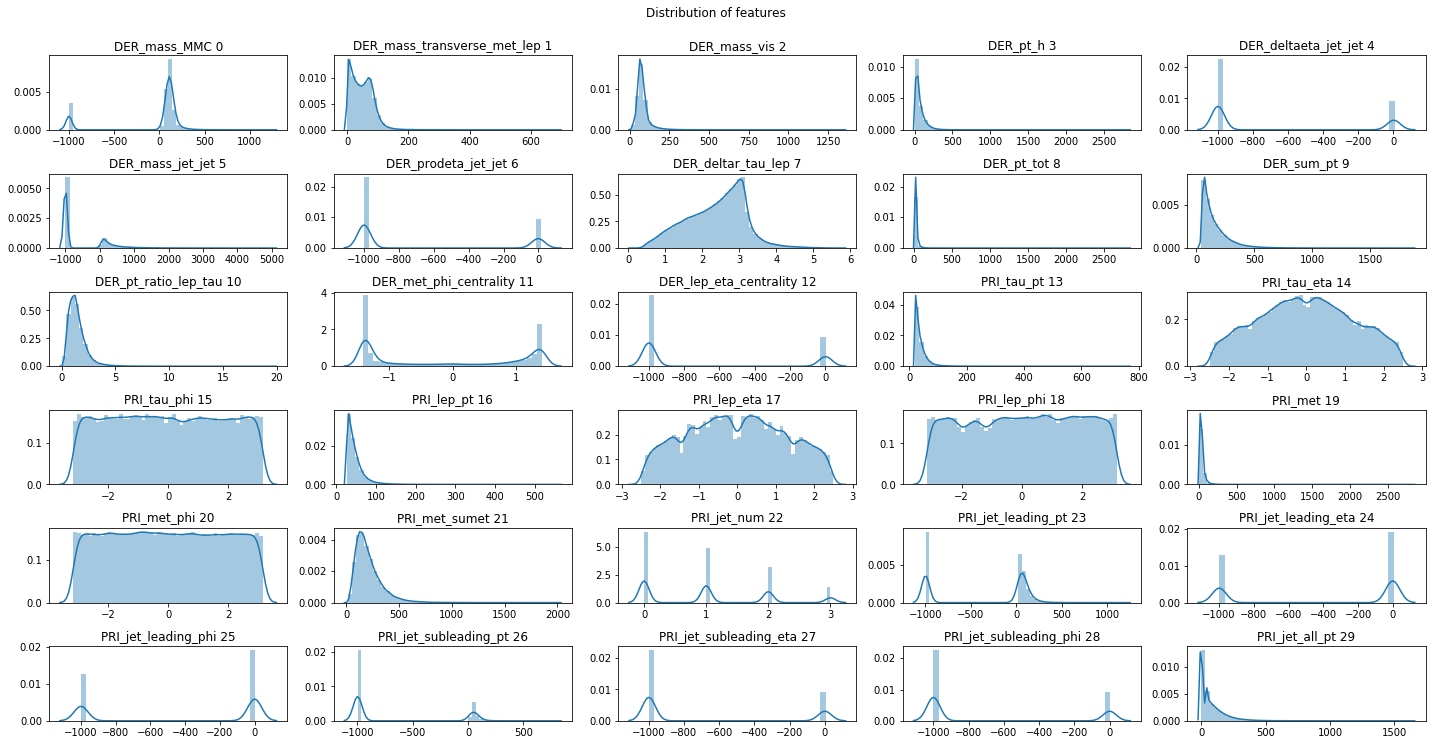

In [232]:
from plots import plot_feature_distribution
plot_feature_distribution(tX, headers, np.arange(len(headers)), "Distribution of features", 5, 6)

As we can see from these plots, different features have different distributions. We can also notice that there seems to be one categorical feature, namely `PRI_jet_num`. This feature is the number of jets used during the experiment. If we look at the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), we can see that some feature are actually affected by the number of jets used.

Features affected by undefined values:
- `DER_mass_MMC` ID=0: undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` ID=4 : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` ID=5: undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` ID=6: undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` ID=12: undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` ID=23: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` ID=24: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` ID=25: undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` ID=26: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` ID=27: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` ID=28: undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution.

For now, we will split the dataset into 6 categories:
- `tX_0, y_0` : Features and labels for experiments with 0 jets, that have a defined `DER_mass_MMC`
- `tX_0_nm,, y_0_nm`:  Features and labels for experiments with 0 jets, that have an undefined `DER_mass_MMC`
- `tX_1, y_1` : Features and labels for experiments with 1 jet, that have a defined `DER_mass_MMC`
- `tX_1_nm, y_1_nm`: Features and labels for experiments with 1 jet, that have an undefined `DER_mass_MMC`
- `tX_2, y_2` : Features and labels for experiments with more than 1 jets
- `tX_2_nm, y_2_nm`: Features and labels for experiments with more than 1 jet, that have an undefined `DER_mass_MMC`



In [4]:
from data_processing import split_dataset

jet_column = 22
mass_col = 0
tX_0, y_0, tX_0_nm, y_0_nm, tX_1, y_1, tX_1_nm, y_1_nm, tX_2, y_2, tX_2_nm, y_2_nm = split_dataset(tX, y, jet_col=jet_column, mass_col=0) # Split into each category

Now that we have split the dataset, we need to select the columns that are meaningful for each category, and add some features using polynomial expansion, exponential, logarithm and so on. For that, we have created a function `enhance_features`. This function adds all the expansions and performs PCA to project the feature matrix on a new basis

In [5]:
from data_processing import prepare_for_training
from implementations import reg_logistic_regression, ridge_regression
from cross_validation import cross_validate_degrees

def select_features(x, y, train_ratio, max_iters, gamma, lambda_):
    x_train, y_train, x_test, y_test = prepare_for_training(x, y, None, train_ratio)
    initial_w = np.zeros((x_train.shape[1], 1))
    weights, loss = reg_logistic_regression_l1(y_train, x_train, lambda_, initial_w, max_iters, gamma, _print=False)

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Regularized Logistic regression got score of {score}, loss of {loss}")
    
    #Select features that cumulate 95% of the weights
    perc = (np.abs(weights) / np.sum(np.abs(weights)))
    with_index = [(i, x) for i, x in enumerate(perc.ravel())]
    sorted_perc = np.array(sorted(with_index, key=lambda x: x[1], reverse=True))
    cum = np.cumsum([x[1] for x in sorted_perc])
    selected_cols = sorted_perc[np.where(cum <= 0.95)[0]][:, 0].astype(int)
    print(f"Feature selection using L1 regularization selected {len(selected_cols)} features")
    return selected_cols

def train_ridge_model(x, y, train_ratio, cols, lambda_):
    x_train, y_train, x_test, y_test = prepare_for_training(x, y, cols, train_ratio, logistic=False)
    weights, loss = ridge_regression(y_train, x_train, lambda_)

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Ridge regression got score of {score}, loss of {loss}")
    return weights

def train_logistic_model(x, y, train_ratio, cols, gamma, lambda_, max_iters):
    x_train, y_train, x_test, y_test = prepare_for_training(x, y, cols, train_ratio, logistic=True)
    initial_w = np.zeros((x_train.shape[1], 1))
    
    weights, loss = reg_logistic_regression(y_train, x_train, lambda_, initial_w, max_iters, gamma)
    

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Regularized logisitc regression got score of {score}, loss of {loss}")
    return weights

#### A few global variable declarations

In [6]:
from feature_expansion import expand_features

In [9]:
train_ratio = 0.9

### Category 0

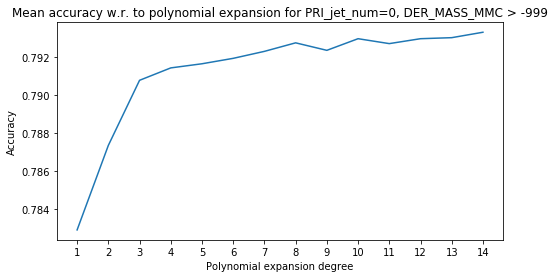

In [123]:
cross_validate_degrees(tX_0, y_0, 1e-2, np.arange(1, 15), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC > -999")

As we can see, a degree of 7 gives the highest accuracy

In [127]:
degree_0 = 1
tX_0_exp = expand_features(tX_0, degree_0)

Performing polynomial expansion up to degree 1
Matrix has now 42 features


In [ ]:
cross_validate_reg(tX_0_exp, y_0, selected_cols_0, 1e-5, np.logspace(-4, 0, 5), 4, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=0, DER_MASS_MMC > -999")

In [184]:
w_0 = train_logistic_model(tX_0_exp, y_0, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_0_exp, y_0, train_ratio, None, 1e-2)

Gradient Descent(0/999): loss=46032.597408166526
Gradient Descent(100/999): loss=29291.421622892085
Gradient Descent(200/999): loss=29033.186702400933
Gradient Descent(300/999): loss=28943.460160167182
Gradient Descent(400/999): loss=28895.533237079442
Gradient Descent(500/999): loss=28863.468448578395
Gradient Descent(600/999): loss=28839.06067557705
Gradient Descent(700/999): loss=28819.08789343502
Gradient Descent(800/999): loss=28802.067179972524
Gradient Descent(900/999): loss=28787.217768357797
Regularized logisitc regression got score of 0.8070199213985635, loss of 28774.07738683825


### Category 0, no mass defined

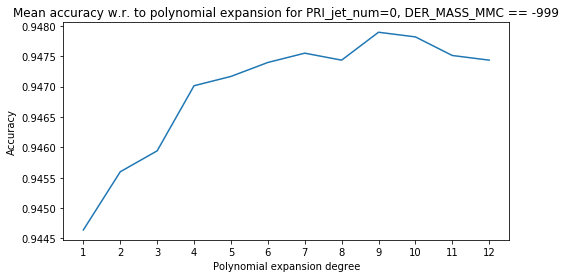

In [67]:
cross_validate_degrees(tX_0_nm, y_0_nm, 1e-4, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC == -999")

In [186]:
degree_0_nm = 1
tX_0_nm_exp = expand_features(tX_0_nm, degree_0_nm)

Performing polynomial expansion up to degree 1
Matrix has now 39 features


In [187]:
w_0_nm = train_logistic_model(tX_0_nm_exp, y_0_nm, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_0_nm_exp, y_0_nm, train_ratio, None, 1e-2)

Gradient Descent(0/999): loss=16295.890214964315
Gradient Descent(100/999): loss=4214.3067339548925
Gradient Descent(200/999): loss=3949.8529248075265
Gradient Descent(300/999): loss=3880.6315984238645
Gradient Descent(400/999): loss=3848.089700089409
Gradient Descent(500/999): loss=3828.8048149527904
Gradient Descent(600/999): loss=3816.0746372570957
Gradient Descent(700/999): loss=3807.0763087844834
Gradient Descent(800/999): loss=3800.378212951545
Gradient Descent(900/999): loss=3795.183370444919
Regularized logisitc regression got score of 0.951396861844623, loss of 3791.0197238470073


### Category 1

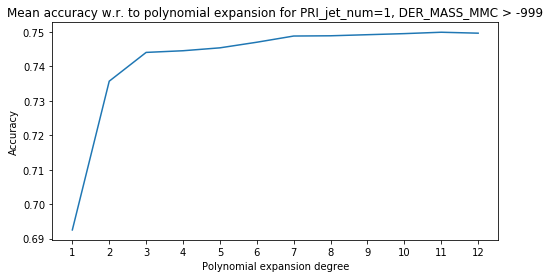

In [122]:
cross_validate_degrees(tX_1, y_1, 1e-2, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [188]:
degree_1 = 1
tX_1_exp = expand_features(tX_1, degree_1)

Performing polynomial expansion up to degree 1
Matrix has now 50 features


In [189]:
w_1 = train_logistic_model(tX_1_exp, y_1, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_1_exp, y_1, train_ratio, None, 1e-4)

Gradient Descent(0/999): loss=43656.48887320703
Gradient Descent(100/999): loss=32476.277002204904
Gradient Descent(200/999): loss=31816.603301258474
Gradient Descent(300/999): loss=31490.51257314077
Gradient Descent(400/999): loss=31289.19043871569
Gradient Descent(500/999): loss=31152.300433084132
Gradient Descent(600/999): loss=31053.3968375716
Gradient Descent(700/999): loss=30978.775422845873
Gradient Descent(800/999): loss=30920.608016108883
Gradient Descent(900/999): loss=30874.099416375804
Regularized logisitc regression got score of 0.7676810972996142, loss of 30836.14911481573


### Category 1, no mass defined

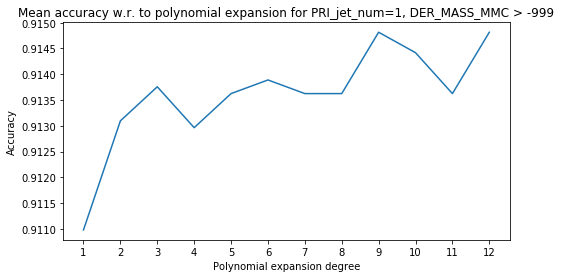

In [117]:
cross_validate_degrees(tX_1_nm, y_1_nm, 1e-2, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [153]:
degree_1_nm = 1
tX_1_nm_exp = expand_features(tX_1_nm, degree_1_nm)

Performing polynomial expansion up to degree 1
Matrix has now 47 features


In [190]:
w_1_nm = train_logistic_model(tX_1_nm_exp, y_1_nm, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_1_nm_exp, y_1_nm, train_ratio, None, 1e-2)

Gradient Descent(0/999): loss=4716.866563710428
Gradient Descent(100/999): loss=2084.3123650295906
Gradient Descent(200/999): loss=1796.4381031405874
Gradient Descent(300/999): loss=1713.6461255112895
Gradient Descent(400/999): loss=1678.118630670308
Gradient Descent(500/999): loss=1658.7046776967245
Gradient Descent(600/999): loss=1646.1900058706801
Gradient Descent(700/999): loss=1637.1525245662929
Gradient Descent(800/999): loss=1630.1116176103874
Gradient Descent(900/999): loss=1624.3466199835784
Regularized logisitc regression got score of 0.9154557463672391, loss of 1619.4697537909374


### Category 2

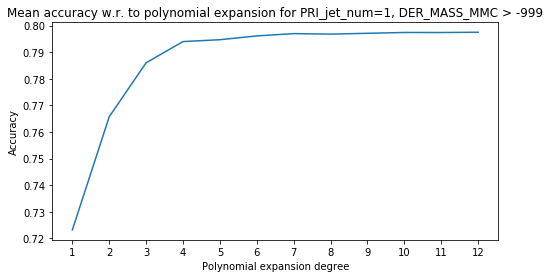

In [80]:
cross_validate_degrees(tX_2, y_2, 1e-4, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [155]:
degree_2 = 1
tX_2_exp = expand_features(tX_2, degree_2)

Performing polynomial expansion up to degree 1
Matrix has now 65 features


In [191]:
w_2 = train_logistic_model(tX_2_exp, y_2, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_2_exp, y_2, train_ratio, None, 1e-4)

Gradient Descent(0/999): loss=42491.30846268577
Gradient Descent(100/999): loss=28801.48987073249
Gradient Descent(200/999): loss=27839.84278620651
Gradient Descent(300/999): loss=27358.28547609574
Gradient Descent(400/999): loss=27058.41711871725
Gradient Descent(500/999): loss=26852.35968339276
Gradient Descent(600/999): loss=26701.939778862565
Gradient Descent(700/999): loss=26587.36869442454
Gradient Descent(800/999): loss=26497.265190237296
Gradient Descent(900/999): loss=26424.597888116896
Regularized logisitc regression got score of 0.8043159130945391, loss of 26364.784080986195


### Category 2, no mass defined

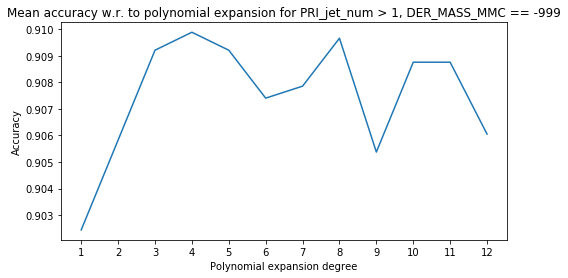

In [89]:
cross_validate_degrees(tX_2_nm, y_2_nm, 1e-4, np.arange(1, 13), 4, "Mean accuracy w.r. to polynomial expansion for PRI_jet_num > 1, DER_MASS_MMC == -999")

In [192]:
degree_2_nm = 1
tX_2_nm_exp = expand_features(tX_2_nm, degree_2_nm)
w_2_nm = train_logistic_model(tX_2_nm_exp, y_2_nm, train_ratio, None, 1e-5, 0, 1000)#train_ridge_model(tX_2_nm_exp, y_2_nm, train_ratio, None, 1e-4)

Performing polynomial expansion up to degree 1
Matrix has now 62 features
Gradient Descent(0/999): loss=2762.884661711942
Gradient Descent(100/999): loss=1469.1833127406485
Gradient Descent(200/999): loss=1215.9005045332092
Gradient Descent(300/999): loss=1124.3483397824164
Gradient Descent(400/999): loss=1081.5752813422478
Gradient Descent(500/999): loss=1058.132591082985
Gradient Descent(600/999): loss=1043.7526479945802
Gradient Descent(700/999): loss=1034.135112682257
Gradient Descent(800/999): loss=1027.2381110444371
Gradient Descent(900/999): loss=1021.9996754257893
Regularized logisitc regression got score of 0.9029345372460497, loss of 1017.8279113952032


## Generate predictions and save ouput in csv format for submission:

In [193]:
from data_processing import prepare_for_testing

In [194]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [200]:
def predict_testset(x, h, degrees, cols, w):
    x = expand_features(x, degrees, print_=False)
    x = prepare_for_testing(x, logistic=True)
    print(x.shape)
    #x = x[:, cols]
    y_pred = predict_labels(w, x)
    return y_pred

In [196]:
tX_0_test, ids_0, tX_0_nm_test, ids_0_nm, tX_1_test, ids_1, tX_1_nm_test, ids_1_nm, tX_2_test, ids_2, tX_2_nm_test, ids_2_nm = split_dataset(tX_test, ids_test, jet_col=22, mass_col=0) # Split into each category

In [197]:
y_pred_0 = predict_testset(tX_0_test, headers, degree_0, None, w_0)
y_pred_0_nm = predict_testset(tX_0_nm_test, headers, degree_0_nm, None, w_0_nm)

(168195, 43)
(59263, 40)


In [198]:
y_pred_1 = predict_testset(tX_1_test, headers, degree_1, None, w_1)
y_pred_1_nm = predict_testset(tX_1_nm_test, headers, degree_1_nm, None, w_1_nm)

(158095, 51)
(17243, 48)


In [199]:
y_pred_2 = predict_testset(tX_2_test, headers, degree_2, None, w_2)
y_pred_2_nm = predict_testset(tX_2_nm_test, headers, degree_2_nm, None, w_2_nm)

(155460, 66)
(9982, 63)


In [201]:
ids_test = np.concatenate([ids_0, ids_0_nm, ids_1, ids_1_nm, ids_2, ids_2_nm])
y_pred = np.concatenate([y_pred_0, y_pred_0_nm, y_pred_1, y_pred_1_nm, y_pred_2, y_pred_2_nm])

In [202]:
y_pred.shape[0] == tX_test.shape[0]

True

In [203]:
OUTPUT_PATH = 'submission.csv' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights_ridge, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [204]:
import pandas as pd

In [205]:
labels = pd.read_csv('../data/solution-with-features.csv')[['Id', 'Prediction']]
pred = pd.read_csv('submission.csv')

In [206]:
c = pred.merge(labels, on='Id')

In [207]:
len(c[c['Prediction_x'] == c['Prediction_y']]) / len(pred)

0.8160876252556147